In [ ]:
import numpy as np
from scipy import sparse as sps
from os import makedirs
from os.path import join, exists
from matplotlib import pyplot as plt, ticker
plt_save_kwargs = dict({"bbox_inches": "tight", "pad_inches": 0.2})
ffont = {'family': 'monospace', 'size': 25}

# ------------- Convenience functions -----------
def mantexp(num):
    # Generate the mantissa an exponent
    if num == 0:
        return 0,0
    exponent = int(np.log10(np.abs(num)))
    mantissa = num/(10**exponent)
    if np.abs(mantissa) < 1:
        mantissa *= 10
        exponent -= 1
    return mantissa,exponent
def generate_sci_fmt(xmin,xmax,numdiv=100):
    # Print to two sig figs
    eps = (xmax-xmin)/numdiv
    #print("eps = {}".format(eps))
    general_sci_fmt = lambda num,pos: sci_not_precision(num,eps)
    return general_sci_fmt
def sci_not_precision(num,eps):
    # Specify a number to an accuracy of epsilon/10
    #print("num = {}".format(num))
    if np.abs(num) < eps*1e-3: 
        #print("num = {}; returning 0".format(num))
        return "0"
    Mn,En = mantexp(num)
    Me,Ee = mantexp(eps)
    # Need Ee+1 places past the decimal point
    #digs = np.abs(Ee) # Wrong for large eps
    # Need enough digits to distinguish num from num+eps
    digs = max(0,En-Ee)
    #print("digs = {}".format(digs))
    num_to_prec = eval(("{:."+str(digs)+"e}").format(num))
    #print("num_to_prec = {}".format(num_to_prec))
    # Now format it accordingly
    Mn,En = mantexp(num_to_prec)
    if np.abs(En) > 2:
        #sci = ("{:."+str(digs)+"f}\\times 10^{}").format(Mn,En)
        sci = ("{:."+str(digs)+"f}").format(Mn)
        #sci = "%s\\times 10^{%d}"%(sci,En)
        sci = "%se%d"%(sci,En)
    else:
        #sci = ("{:."+str(digs)+"f}").format(num_to_prec)
        sci = ("{:."+str(digs)+"f}").format(num_to_prec)
    return sci #num_to_prec 
def fmt(num,pos):
    return '{:.1f}'.format(num)
def fmt2(num,pos):
    return '{:.2f}'.format(num)
def fmt3(num,pos):
    return '{:.3f}'.format(num)
def sci_fmt(num,lim):
    return '{:.1e}'.format(num)
def sci_fmt_short(num,lim):
    return '{:.0e}'.format(num)
def sci_fmt_latex0(num):
    # Convert a number to scientific notation
    exponent = int(np.log10(np.abs(num)))
    mantissa = num/(10**exponent)
    if np.abs(mantissa) < 1:
        mantissa += np.sign(mantissa)
        exponent -= 1
    if exponent != 0:
        sci = "%.0f\\times 10^{%d}" % (mantissa,exponent)
    else:
        sci = r"%.0f" % mantissa
    return sci
def sci_fmt_latex1(num):
    # Convert a number to scientific notation
    exponent = int(np.log10(np.abs(num)))
    mantissa = num/(10**exponent)
    if np.abs(mantissa) < 1:
        mantissa += np.sign(mantissa)
        exponent -= 1
    if exponent != 0:
        sci = "%.1f\\times 10^{%d}" % (mantissa,exponent)
    else:
        sci = r"%.1f" % mantissa
    return sci
def sci_fmt_latex(num):
    # Convert a number to scientific notation
    exponent = int(np.log10(np.abs(num)))
    mantissa = num/(10**exponent)
    if np.abs(mantissa) < 1:
        mantissa += np.sign(mantissa)
        exponent -= 1
    if exponent != 0:
        sci = "%.2f\\times 10^{%d}" % (mantissa,exponent)
    else:
        sci = r"$%.2f$" % mantissa
    return sci
def first_derivative(F,lower,upper,dz):
    # Compute the first z derivatives any field
    Nt,n = F.shape
    Fz = np.zeros([Nt,n])
    Fz[:,1:-1] = (F[:,2:n] - F[:,0:n-2]) / (2*dz)
    Fz[:,0] = (F[:,1] - lower)/(2*dz)
    Fz[:,-1] = (upper - F[:,-2])/(2*dz)
    return Fz

def D1mat(n,dz,lower_value,lower_type,upper_value,upper_type):
    # coeff is the coefficient to multiply the derivative by
    D = np.zeros((n,n))
    C = np.zeros(n)
    D[np.arange(1,n-1),np.arange(2,n)] = 1.0/(2*dz)
    D[np.arange(1,n-1),np.arange(n-2)] = -1.0/(2*dz)
    # Lower boundary
    if lower_type == 'dirichlet':
        D[0,1] = 1.0/(2*dz)
        C[0] = -lower_value/(2*dz)
    elif lower_type == 'neumann':
        D[0,[0,1]] = 2.0/3*np.array([-1,1])/dz
        C[0] = 1.0/3*lower_value
    # Upper boundary
    if upper_type == 'dirichlet':
        D[n-1,n-2] = -1.0/(2*dz)
        C[n-1] = upper_value/(2*dz)
    elif upper_type == 'neumann':
        D[n-1,[n-2,n-1]] = 2.0/3*np.array([-1,1])/dz
        C[n-1] = 1.0/3*upper_value
    return C,D

def D2mat(n,dz,lower_value,lower_type,upper_value,upper_type):
    D = np.zeros((n,n))
    C = np.zeros(n)
    D[np.arange(1,n-1),np.arange(1,n-1)] = -2.0/dz**2
    D[np.arange(1,n-1),np.arange(n-2)] = 1.0/dz**2
    D[np.arange(1,n-1),np.arange(2,n)] = 1.0/dz**2
    # Lower boundary
    if lower_type == 'dirichlet':
        D[0,[0,1]] = np.array([-2,1])/dz**2
        C[0] = lower_value/dz**2
    elif lower_type == 'neumann':
        D[0,[0,1]] = np.array([-1,1])/(1.5*dz**2)
        C[0] = -1.0/(1.5*dz)*lower_value
    # Upper boundary
    if upper_type == 'dirichlet':
        D[n-1,[n-2,n-1]] = np.array([1,-2])/dz**2
        C[n-1] = upper_value/dz**2
    elif upper_type == 'neumann':
        D[n-1,[n-2,n-1]] = -np.array([-1,1])/(1.5*dz**2)
        C[n-1] = 1.0/(1.5*dz)*upper_value
    return C,D

def second_derivative(F,lower,upper,dz):
    # Compute the first z derivatives any field
    Nt,n = F.shape
    Fzz = np.zeros([Nt,n])
    Fzz[:,1:-1] = (F[:,2:n] + F[:,0:n-2] - 2*F[:,1:-1]) / (dz**2)
    Fzz[:,0] = (F[:,1] + lower - 2*F[:,0])/(dz**2)
    Fzz[:,-1] = (upper + F[:,-2] - 2*F[:,-1])/(dz**2)
    return Fzz
    
# --------------------------------------------------------------------------

class HoltonMassModel:
    def __init__(self, config):
        self.initialize_params(config)
    @staticmethod
    def default_config():
        # --------- Oft-varied parameters ----------
        du_per_day = 1.0 # noise strength 
        hB_d = 38.5 # bottom topography height, with _d meaning "dimensional units"
        # ----------- All the other parameters ----------
        config = {
           'rad': 6370.0e3,                 # earth radius [m]
           'day': 24*3600.0,                # duration of a day [s]
           'g': 9.82,                       # gravitational acceleration [m/s^2]
           'phi0': np.pi/3,                 # central latitude 
           'sx': 2,                         # zonal wavenumber of perturbation streamfunction  
           'sy': 3,                         # meridional wavenumber of polar night jet 
           'zB_d': 0.0,                     # bottom altitude (minus tropopause height)
           'zT_d': 70.0e3,                  # top altitude (minus tropopause height)
           'H': 7.0e3,                      # height scale [m]
           'Omega': 2*np.pi/(24*3600),      # angular velocity of Earth's rotation
           'Nsq_d': 4.0e-4,                 # Brunt-Vaisala frequency [s^{-2}]
           'ideal_gas_constant': 8.314,     # universal gas constant [J/K/mol]
           'eps': 8.0/(3*np.pi),            # projection constant of sin^2 onto sin or something like that 
           'UR_0_d': 10.0,                  # radiative wind at bottom [m/s] 
           'gamma': 1.5,                    # vertical wind shear 
           'hB_d': 38.5,                    # This is a key control parameter
           'nfreq': 3,                      # how many spatial z-wavenumbers to excite stochastically 
           'Nz': 26,                        # number of z-levels + 1; this leaves 3*(Nz-1) independent degrees of freedom
           'length': 2.5e5,                 # scale for nondimensionalization [m]
           'time': 24*3600.0,               # scale for nondimensionalization [s]
           'du_per_day': 1.0,               # noise strength parameter 
           'dt_sim': 0.005,                 # numerical timestep 
           'ref_alt': 30,                   # altitude of zonal wind to use for defining A and B 
        }
        return config
    @staticmethod
    def strrep_config(config):
        vbl_param_str = (f'du{config["du_per_day"]}_h{config["hB_d"]}').replace('.','p')
        return vbl_param_str
    def initialize_params(self, config):
        #The z points will be (0, dz, 2*dz, ..., (Nz-1)*dz, Nz*dz). Therefore there are 
        #Nz+1 variables (some of them actually known) and dz=(zT-zB)/Nz
        params = config.copy()
        n = params['Nz']+1 #Number of points including boundaries
        params['state_dim'] = 3*(params['Nz']-1)
        #Dimensional variables
        params['f0_d'] = 2*params['Omega']*np.sin(params['phi0'])
        params['beta_d'] = 2*params['Omega']*np.cos(params['phi0'])/params['rad']
        params['k_d'] = params['sx']/(params['rad']*np.cos(params['phi0']))
        params['l_d'] = params['sy']/params['rad']
        params['dz_d'] = (params['zT_d']-params['zB_d'])/params['Nz']
        params['z_d'] = np.linspace(params['zB_d'],params['zT_d'],params['Nz']+1)
        params['alpha_d'] = (1.5 + np.tanh((params['z_d']/1000-25)/7.0))*1e-6
        params['alpha_z_d'] = 1e-6/7000 * 1.0/np.cosh((params['z_d']/1000-25)/7.0)**2
        params['UR_d'] = params['UR_0_d'] + params['gamma']*params['z_d']/1000
        params['UR_z_d'] = params['gamma']/1000*np.ones(n)
        params['UR_zz_d'] = np.zeros(n)
        params['Psi0_d'] = params['g']*params['hB_d']/params['f0_d']
        params['fn'] = params['f0_d']**2/params['Nsq_d']
        params['lap_d'] = params['k_d']**2 + params['l_d']**2 + 1.0/(4*params['H']**2)*params['fn']
        #Dimensionless variables
        params['Gsq'] = 1.0/(params['length']**2/params['H']**2*params['fn'])
        params['k'] = params['k_d']*params['length']
        params['l'] = params['l_d']*params['length']
        params['dz'] = params['dz_d']/params['H']
        params['zT'] = params['zT_d']/params['H']
        params['zB'] = params['zB_d']/params['H']
        params['z'] = params['z_d']/params['H']
        params['beta'] = params['beta_d']*params['time']*params['length']
        params['alpha'] = params['alpha_d']*params['time']
        params['alpha_z'] = params['alpha_z_d']*params['time']*params['H']
        params['UR'] = params['UR_d']*params['time']/params['length']
        params['UR_0'] = params['UR_0_d']*params['time']/params['length']
        params['UR_z'] = params['UR_z_d']*params['time']*params['H']/params['length']
        params['UR_zz'] = params['UR_zz_d']*params['time']*params['H']**2/params['length']
        params['lap'] = params['Gsq']*(params['k']**2 + params['l']**2) + 1/4.0
        params['Psi0'] = params['Psi0_d']*params['time']/params['length']**2
        #Some handy shortcuts
        params['zi'] = np.argmin(np.abs(params['z_d'][1:-1]/1000-params['ref_alt']))
        params['states'] = ['r','v']
        #Noise
        params['sig_u'] = params['du_per_day']*np.sqrt(params['time']**3/params['length']**2/(3600.0*24))
        n = params['Nz']-1
        sigmat = np.zeros((3*n,params['nfreq'])) 
        # Wdot = np.zeros(3*n)
        for k in range(params['nfreq']):
            sinkz_shift = np.sin((k+0.5)*np.pi*params['z']/params['zT'])[1:-1]
            sigmat[2*n:,k] = params['sig_u']*sinkz_shift
            # Wdot[[k,n+k,2*n+k]] = mag[k]
        params['sig_mat'] = sps.csr_matrix(sigmat)
        # Left-hand inversion operator
        Lpsi = np.zeros((n,n))
        Lu = np.zeros((n,n))
        Lpsi[np.arange(n),np.arange(n)] = -(params['Gsq']*(params['k']**2+params['l']**2) + 0.25) - 2.0/params['dz']**2
        Lpsi[np.arange(n-1),np.arange(1,n)] = 1.0/params['dz']**2
        Lpsi[np.arange(1,n),np.arange(n-1)] = 1.0/params['dz']**2
        Lu[np.arange(n),np.arange(n)] = -params['Gsq']*params['l']**2 - 2.0/params['dz']**2
        Lu[np.arange(n-1),np.arange(1,n)] = -1.0/(2*params['dz']) + 1.0/params['dz']**2
        Lu[np.arange(1,n),np.arange(n-1)] = 1.0/(2*params['dz']) + 1.0/params['dz']**2
        # Boundary!
        Lu[n-1,n-2] = 2.0/(3*params['dz']) + 2.0/(3*params['dz']**2)
        Lu[n-1,n-1] = -params['Gsq']*params['l']**2 - 2.0/(3*params['dz']) - 2.0/(3*params['dz']**2)
        # Invert
        params['Lpsi_inv'] = sps.csr_matrix(np.linalg.inv(Lpsi))
        params['Lu_inv'] = sps.csr_matrix(np.linalg.inv(Lu))
        dz = params['dz']
    
        
        self.Xz_vec,self.Xz_mat = D1mat(n,dz,params['Psi0'],'dirichlet',0,'dirichlet')
        self.Xzz_vec,self.Xzz_mat = D2mat(n,dz,params['Psi0'],'dirichlet',0,'dirichlet')
        self.Yz_vec,self.Yz_mat = D1mat(n,dz,0,'dirichlet',0,'dirichlet')
        self.Yzz_vec,self.Yzz_mat = D2mat(n,dz,0,'dirichlet',0,'dirichlet')
        self.Uz_vec,self.Uz_mat = D1mat(n,dz,params['UR_0'],'dirichlet',params['UR_z'][-1],'neumann')
        self.Uzz_vec,self.Uzz_mat = D2mat(n,dz,params['UR_0'],'dirichlet',params['UR_z'][-1],'neumann')
        # Get constant and linear parts first
        self.Jlin = np.zeros((3*n,3*n))
        # Re(Psi)
        a = params['alpha'][1:-1]
        az = params['alpha_z'][1:-1]
        self.Jlin[:n,:n] += np.diag(a/4-az/2) - (az*self.Xz_mat.T + a*self.Xzz_mat.T).T
        self.Jlin[:n,n:2*n] += params['Gsq']*params['k']*params['beta']*np.eye(n)
        # Im(Psi)
        self.Jlin[n:2*n,n:2*n] += np.diag(a/4-az/2) - (az*self.Yz_mat.T + a*self.Yzz_mat.T).T
        self.Jlin[n:2*n,:n] += -params['Gsq']*params['k']*params['beta']*np.eye(n)
        # U
        self.Jlin[2*n:3*n,2*n:3*n] = -((az-a)*self.Uz_mat.T + a*self.Uzz_mat.T).T

        self.params = params
        return 
    def drift_fun(self,x):
        n = self.params['Nz']-1
        Nx = len(x)
        # Build the right-hand side
        rhs = np.zeros((Nx,3*n))
        X = x[:,0:n]
        Y = x[:,n:2*n]
        U = x[:,2*n:3*n]
        Xz = first_derivative(X,self.params['Psi0'],0,self.params['dz'])
        Xzz = second_derivative(X,self.params['Psi0'],0,self.params['dz'])
        Yz = first_derivative(Y,0,0,self.params['dz'])
        Yzz = second_derivative(Y,0,0,self.params['dz'])
        U_upper = 1.0/3*(4*U[:,-1] - U[:,-2] + 2*self.params['dz']*self.params['UR_z'][-1])
        Uz = first_derivative(U,self.params['UR_0'],U_upper,self.params['dz'])
        Uzz = second_derivative(U,self.params['UR_0'],U_upper,self.params['dz'])
        # Re(Psi)
        rhs[:,:n] = (self.params['alpha'][1:-1]/4 - self.params['alpha_z'][1:-1]/2)*X + self.params['Gsq']*self.params['k']*self.params['beta']*Y - self.params['alpha_z'][1:-1]*Xz - self.params['alpha'][1:-1]*Xzz
        rhs[:,:n] += (-self.params['k']*self.params['eps']*Y)*((self.params['k']**2*self.params['Gsq']+0.25)*U - Uz + Uzz)
        rhs[:,:n] += self.params['k']*self.params['eps']*Yzz*U
        # Im(Psi)
        rhs[:,n:2*n] = (self.params['alpha'][1:-1]/4 - self.params['alpha_z'][1:-1]/2)*Y - self.params['Gsq']*self.params['k']*self.params['beta']*X - self.params['alpha_z'][1:-1]*Yz - self.params['alpha'][1:-1]*Yzz
        rhs[:,n:2*n] += self.params['k']*self.params['eps']*X*((self.params['k']**2*self.params['Gsq']+0.25)*U - Uz + Uzz)
        rhs[:,n:2*n] += -self.params['k']*self.params['eps']*Xzz*U
        # U
        rhs[:,2*n:3*n] = ((self.params['alpha_z'][1:-1]-self.params['alpha'][1:-1])*self.params['UR_z'][1:-1]) + self.params['alpha'][1:-1]*self.params['UR_zz'][1:-1] 
        rhs[:,2*n:3*n] += -(self.params['alpha_z'][1:-1]-self.params['alpha'][1:-1])*Uz - self.params['alpha'][1:-1]*Uzz
        rhs[:,2*n:3*n] += self.params['eps']*self.params['k']*self.params['l']**2/2*np.exp(self.params['z'][1:-1])*(-X*Yzz + Y*Xzz)
        # Now invert the Laplacian on the left
        #xdot = self.params['L_inv'].dot(rhs.T).T
        xdot = np.zeros((Nx,3*n))
        xdot[:,:n] = (self.params['Lpsi_inv'].dot(rhs[:,:n].T)).T 
        xdot[:,n:2*n] = (self.params['Lpsi_inv'].dot(rhs[:,n:2*n].T)).T 
        xdot[:,2*n:3*n] = (self.params['Lu_inv'].dot(rhs[:,2*n:3*n].T)).T 
        return xdot
    def drift_jacobian_fun(self,x):
        # x is just a single instance
        n = self.params['Nz']-1
        a = self.params['alpha'][1:-1]
        az = self.params['alpha_z'][1:-1]
        z = self.params['z'][1:-1]
        dz = self.params['dz']
        J = self.Jlin.copy()
        X = x[0:n]
        Y = x[n:2*n]
        U = x[2*n:3*n]
        Xz = self.Xz_mat.dot(X) + self.Xz_vec
        Xzz = self.Xzz_mat.dot(X) + self.Xzz_vec
        Yz = self.Yz_mat.dot(Y) + self.Yz_vec
        Yzz = self.Yzz_mat.dot(Y) + self.Yzz_vec
        Uz = self.Uz_mat.dot(U) + self.Uz_vec
        Uzz = self.Uzz_mat.dot(U) + self.Uzz_vec
        # The matrix will consist of nine blocks
        # Re(Psi)
        J[:n,n:2*n] += -self.params['k']*self.params['eps']*np.diag((self.params['k']**2*self.params['Gsq']+0.25)*U - Uz + Uzz) + self.params['k']*self.params['eps']*(U*self.Yzz_mat.T).T
        J[:n,2*n:3*n] += -(self.params['k']*self.params['eps']*Y*((self.params['k']**2*self.params['Gsq']+0.25)*np.eye(n) - self.Uz_mat + self.Uzz_mat).T).T + self.params['k']*self.params['eps']*np.diag(Yzz)
        # Im(Psi)
        J[n:2*n,:n] += self.params['k']*self.params['eps']*np.diag((self.params['k']**2*self.params['Gsq']+0.25)*U - Uz + Uzz) - self.params['k']*self.params['eps']*(U*self.Xzz_mat.T).T
        J[n:2*n,2*n:3*n] += (self.params['k']*self.params['eps']*X*((self.params['k']**2*self.params['Gsq']+0.25)*np.eye(n) - self.Uz_mat + self.Uzz_mat).T).T - self.params['k']*self.params['eps']*np.diag(Xzz)
        # U
        J[2*n:3*n,:n] += self.params['eps']*self.params['k']*self.params['l']**2/2*np.diag(np.exp(z)).dot((-Yzz*np.eye(n).T + Y*self.Xzz_mat.T).T)
        J[2*n:3*n,n:2*n] += self.params['eps']*self.params['k']*self.params['l']**2/2*np.diag(np.exp(z)).dot((-X*self.Yzz_mat.T + Xzz*np.eye(n).T).T)
        # Now invert
        J[:n,:] = self.params['Lpsi_inv'].dot(J[:n,:])
        J[n:2*n,:] = self.params['Lpsi_inv'].dot(J[n:2*n,:])
        J[2*n:3*n,:] = self.params['Lu_inv'].dot(J[2*n:3*n,:])
        return J
    def diffusion_fun(self,x,rng):
        wdot = rng.normal(size=(self.params['nfreq'],len(x)))
        diff_term = (self.params['sig_mat'].dot(wdot)).T
        return diff_term
    def diffusion_mat(self,x):
        return self.params['sig_mat']
    def integrate_euler_maruyama(self,x0,t_save,stochastic_flag=True,print_interval=None,seed=2919):
        # Integrate with Euler-Maruyama. Computational timestep of dt_sim,
        # and save times of t_save
        # x0 is an array of initial conditions
        rng = np.random.default_rng(seed=seed)
        num_traj,x0dim = x0.shape
        assert x0dim == self.params['state_dim']
        Nt_save = len(t_save)
        Nt_sim = int(np.ceil((t_save[-1]-t_save[0])/self.params['dt_sim'])) + 1
        dt_sim = (t_save[-1] - t_save[0])/(Nt_sim - 1)
        x = np.zeros((Nt_save,num_traj,self.params['state_dim']))
        x[0] = np.copy(x0)
        xold = np.copy(x0)
        xnew = np.copy(x0)
        ti = 1 # Next save index
        told = t_save[0]
        tnew = told
        while tnew < t_save[-1]:
            xnew[:] = xold[:] + dt_sim*self.drift_fun(xold)
            if stochastic_flag:
                xnew += np.sqrt(dt_sim)*self.diffusion_fun(xold, rng)
            #print("xnew - xold = {}".format(xnew - xold))
            tnew = told + dt_sim
            #print("tnew = {}".format(tnew))
            while (ti < Nt_save) and (t_save[ti] <= tnew):
                frac = (t_save[ti] - told)/(tnew - told)
                x[ti] = xold*(1 - frac) + xnew*frac 
                ti += 1
            if print_interval is not None:
                if (tnew // print_interval) > (told // print_interval):
                    print("Time {:3.3f} out of {:.3f} ({:3.3f}% done)".format(tnew,t_save[-1],tnew/t_save[-1]*100))
            told = tnew
            xold[:] = xnew
        return x
    def find_fixed_points(self,tmax=300):
        n = self.params['Nz']-1
        # -------------- Initialize two cartoonish states in the basin of attraction of A and B respectively ------------
        x_init = np.zeros((2,3*n)) # first row is a, second row is b
        # Initial streamfunction profile: a linear ramp
        x_init[:,:n] = self.params['Psi0']*(1 - self.params['z'][1:-1]/self.params['zT'])
        x_init[:,n:2*n] = 0.0
        # Initial zonal wind profile: a constant shear for a, and a knee for b
        x_init[0,2*n:3*n] = self.params['UR'][1:-1]
        kneez = np.argmin(np.abs(self.params['z_d'][1:-1] - 35.0e3))  # where the bend happens
        x_init[1,2*n:3*n] = np.maximum(self.params['UR_0'], self.params['UR_0'] + self.params['UR_z'][-1]*(self.params['z'][1:-1] - self.params['z'][kneez]))
        # Should generalize to find periodic orbits
        t_save = np.linspace(0,tmax,10000)
        x = self.integrate_euler_maruyama(x_init,t_save,stochastic_flag=False)
        if np.max(np.abs(x[-1]-x[-2])) > 1e-6 or np.max(np.abs(self.drift_fun(x[-1]))) > 1e-6:
            print("WARNING! Not converged to fixed points")
            print("Gradient magnitudes: {}".format(np.sqrt(np.sum((self.drift_fun(x[-1]))**2, 1))))
        self.xst = x[-1]
        return x,t_save
    def plot_two_snapshots(self,xt0,xt1,suffix0="",suffix1=""):
        n = self.params['Nz']-1
        fig,ax = plt.subplots(ncols=3,figsize=(18,6),sharey=True)
        z = self.params['z_d'][1:-1]/1000
        handles = []
        # Panel 0: altitude-dependent cooling
        ax[0].plot(self.params['alpha_d'][1:-1], z, color='black')
        ax[0].set_xlabel(r"$\alpha(z)$ [s$^{-1}$]",fontdict=ffont)
        ax[0].set_title("Cooling coefficient",fontdict=ffont)
        ax[0].axvline(x=0, linestyle='--', color='black')
        ax[0].tick_params(axis='both', which='major', labelsize=20)
        ax[0].set_ylabel(r"$z$ [km]",fontdict=ffont)
        xlim = ax[0].get_xlim()
        fmt_x = generate_sci_fmt(xlim[0],xlim[1],numdiv=10)
        ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(fmt_x))
        # Panel 1: zonal wind 
        handle, = ax[1].plot(xt0[2*n:3*n]*self.params['length']/self.params['time'],z,color='skyblue',linewidth=1.5,label=suffix0)
        handles += [handle]
        handle, = ax[1].plot(xt1[2*n:3*n]*self.params['length']/self.params['time'],z,color='red',linewidth=1.5,label=suffix1)
        handles += [handle]
        ax[1].set_xlabel(r"$U$ [m/s]",fontdict=ffont)
        ax[1].set_title("Zonal wind",fontdict=ffont)
        ax[1].tick_params(axis='both', which='major', labelsize=20)
        base_x = 20.0
        base_y = 20.0
        xlim,ylim = ax[1].get_xlim(),ax[1].get_ylim()
        ax[1].xaxis.set_major_locator(plt.FixedLocator(np.arange(xlim[0]//base_x,xlim[-1]//base_x+1,1)*base_x))
        ax[1].yaxis.set_major_locator(plt.FixedLocator(np.arange(ylim[0]//base_y,ylim[-1]//base_y+1,1)*base_y))
        if len(suffix0)>0 or len(suffix1)>0:
            ax[1].legend(handles=handles,prop={'size': 25})
        # Panel 2: streamfunction
        x = np.linspace(0,360,50)
        xz,zx = np.meshgrid(x,self.params['z_d'][1:-1]/1000,indexing='ij')
        psi0 = np.outer(np.cos(2*x*np.pi/180),xt0[:n]) - np.outer(np.sin(2*x*np.pi/180),xt0[n:2*n])
        psi1 = np.outer(np.cos(2*x*np.pi/180),xt1[:n]) - np.outer(np.sin(2*x*np.pi/180),xt1[n:2*n])
        psi1 *= np.exp(self.params['z_d'][1:-1]/(2*self.params['H']))*self.params['length']**2/self.params['time']
        psi0 *= np.exp(self.params['z_d'][1:-1]/(2*self.params['H']))*self.params['length']**2/self.params['time']
        im = ax[2].contour(xz,zx,psi0,colors='skyblue')
        im = ax[2].contour(xz,zx,psi1,colors='red')
        ax[2].set_xlabel(r"Longitude [$^\circ$E]",fontdict=ffont)
        dpsi = im.levels[1]-im.levels[0]
        ax[2].set_title(r"Streamfunction [m$^2$/s]",fontdict=ffont) # ($\Delta=%.1e$)"%(dpsi),fontdict=ffont)
        ax[2].tick_params(axis='both', which='major', labelsize=20)
        base_x = 90.0
        base_y = 20.0
        xlim,ylim = ax[2].get_xlim(),ax[2].get_ylim()
        return fig,ax


if __name__ == "__main__":

    # Set up a place to save out 
    base_dir = r"C:\Users\danie\OneDrive\Desktop\SHORT\holton_mass_essentials"


    config = HoltonMassModel.default_config()
    savedir = join(base_dir, HoltonMassModel.strrep_config(config))
    makedirs(savedir, exist_ok=True)
    model = HoltonMassModel(config)
    x_ffp,t_ffp = model.find_fixed_points() # ffp for find fixed points
    print(f'{x_ffp.shape = }')
    fig,ax = model.plot_two_snapshots(x_ffp[0,0,:],x_ffp[0,1,:])
    fig.savefig(join(savedir,"finding_fixed_point_init.png"), **plt_save_kwargs)
    plt.close(fig)
    fig,ax = model.plot_two_snapshots(x_ffp[-1,0,:],x_ffp[-1,1,:])
    fig.savefig(join(savedir,"fixed_points_final.png"), **plt_save_kwargs)
    plt.close(fig)

    # Plot time evolution of zonal-mean zonal wind
    zi = model.params['zi'] # reference altitude
    n = model.params['Nz'] - 1
    uref_toa = x_ffp[:,0,2*n+zi]
    uref_tob = x_ffp[:,1,2*n+zi]
    fig,ax = plt.subplots()
    h2a, = ax.plot(t_ffp, uref_toa, color='dodgerblue', label='To A')
    h2b, = ax.plot(t_ffp, uref_tob, color='red', label='To B')
    ax.set_xlabel("Time")
    ax.set_ylabel("U(30 km)")
    ax.set_title("Journey to fixed points")
    fig.savefig(join(savedir,"journey_to_fixed_points.png"), **plt_save_kwargs)
    plt.close(fig)

    #Run Deterministic trajectory from fixed points

    combined_set = []
    x_init_set = []

    N = 100
    for i in range(N):
        perturb = 2 * np.random.randn(model.params['state_dim'])
        print(perturb)
        x_init = model.xst[:] + perturb
        x_init_set.append(x_init)
    x_init_set = np.stack(x_init_set)
    x_init_set = x_init_set.reshape(2*N,75)
    print(f'{x_init_set.shape = }')
    # Save to .npy
    save_dir = r"/home/fabio/work/HM_and_AI_models/VAE_Model/data"
    # save_path = join(savedir, "vae_initial_conditions.npy")
    # np.save(save_path, x_init_set)
    # print(f"Saved initial conditions to: {save_path}")

    tmax = 100
    dt_save = 1  # save every 1 unit of time
    t_deterministic = np.arange(0, tmax + dt_save, dt_save)
    x_dets = model.integrate_euler_maruyama(x_init_set, t_deterministic, stochastic_flag=False)
    x_dets_100 = x_dets[1:, :, :]                                 # (100, 20, 75)
    long_series = x_dets_100.transpose(1, 0, 2).reshape(-1, 75)   # (2 000, 75)
    np.save(join(save_dir, "time_series_deterministic_new.npy"), long_series)
    # np.save(join(save_dir, "vae_long_series_2000x75.npy"), long_series)
    print(f'{x_dets.shape = }') 

    print(f"long time series is {long_series.shape}")
    zi = model.params['zi']
    n = model.params['Nz'] - 1
    uref_all = x_dets[:,:,2*n + zi] 

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(10, 6))
    print(x_dets.shape)
    for i in range(N*2):
        color = np.random.rand(3,)
        ax.plot(t_deterministic, uref_all[:, i], label=f'Traj {i+1}', color=color)
    ax.set_xlabel('Time')
    ax.set_ylabel('U(30 km)')
    ax.set_ylim([-5, 27.5])
    ax.set_title('Deterministic Trajectories from Various Initial Conditions')
    plt.tight_layout()
    plt.show()

print(long_series)

WARNING! Not converged to fixed points
Gradient magnitudes: [0.00197963 0.12025513]
x_ffp.shape = (10000, 2, 75)
[ 9.32355572e-02  5.19113238e-01 -3.30041593e+00 -2.09786947e+00
 -2.07055245e+00  4.34845471e-03 -1.03952022e+00 -2.79324448e+00
 -1.50376243e+00  4.34758145e-01 -6.05844453e-01  2.14525306e+00
  1.02955657e+00  2.99654633e+00  1.60548057e+00 -3.51731236e+00
 -2.48647547e+00  9.44643728e-01 -1.83919397e+00  1.74442531e+00
 -1.67692814e+00  6.20134237e-01 -2.04498979e+00 -1.51924730e+00
 -1.20783893e+00 -7.11880568e-01  4.52881225e-01 -3.13258891e-01
  1.51309874e+00 -1.56853462e+00  1.54191818e-01 -5.27599859e-01
  1.56268306e+00  6.97841352e-01 -1.13451810e+00  2.37621974e+00
  1.32720596e+00  6.52692412e-01 -3.49423773e+00  4.64478103e+00
 -3.05138801e+00  9.42068543e-01  8.54897088e-01 -5.38249337e-01
 -1.89259430e+00  1.73655415e+00  3.38914062e+00  1.12956139e+00
 -9.81656998e-02  2.89950205e+00 -1.14659723e+00 -3.40815981e-01
  2.09821512e+00 -2.35248366e+00 -1.146039

KeyboardInterrupt: 

In [21]:

valid_index = np.arange(0, 300_000)
print(valid_index)

print(np.random.seed(4838))

num = np.random.permutation(valid_index)
print(num)

[     0      1      2 ... 299997 299998 299999]
None
[ 87890 149574   3273 ...  66220 266532  17178]


long time series is (1000000, 75)
(101, 10000, 75)


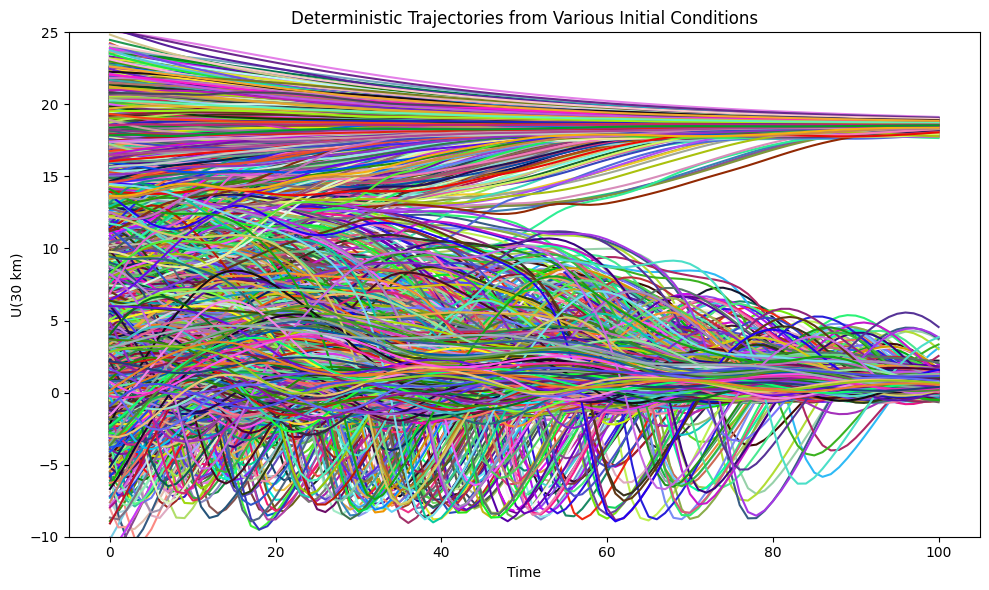

In [23]:
x_init_set = []

save_dir = r"/home/fabio/work/HM_and_AI_models/VAE_Model/data"
load_data = r"/home/fabio/work/HM_and_AI_models/VAE_Model/data/long_run_310k.npy"
psi = np.load(load_data)

N = 10_000

sample = num[:N]

for i in range(N):
    temp_point = psi[sample[i], 0, :]
    x_init_set.append(temp_point)

x_init_set = np.stack(x_init_set)
x_init_set = x_init_set.reshape(N,75)

tmax = 100
dt_save = 1  # save every 1 unit of time

t_deterministic = np.arange(0, tmax + dt_save, dt_save)
x_dets = model.integrate_euler_maruyama(x_init_set, t_deterministic, stochastic_flag=False)
x_dets_100 = x_dets[1:, :, :]                                 # (100, 20, 75)
long_series = x_dets_100.transpose(1, 0, 2).reshape(-1, 75)   # (2 000, 75)
np.save(join(save_dir, "time_series_deterministic_new.npy"), long_series)

print(f"long time series is {long_series.shape}")
zi = model.params['zi']
n = model.params['Nz'] - 1
uref_all = x_dets[:,:,2*n + zi] 

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
print(x_dets.shape)
for i in range(N):
    color = np.random.rand(3,)
    ax.plot(t_deterministic, uref_all[:, i], label=f'Traj {i+1}', color=color)
ax.set_xlabel('Time')
ax.set_ylabel('U(30 km)')
ax.set_ylim([-10, 25])
ax.set_title('Deterministic Trajectories from Various Initial Conditions')
plt.tight_layout()
plt.show()
